# Cell/particle Counting and scoring stained objects

This notebook demonstrates how to process plates associated to the paper ['Integration of biological data by kernels on graph nodes allows prediction of new genes involved in mitotic chromosome condensation.'](http://dx.doi.org/10.1091/mbc.E13-04-0221) using [CellProfiler](http://cellprofiler.org/).
We use the example pipeline [Cell/particle counting, and scoring the percentage of stained objects](http://cellprofiler.org/examples/#PercentPositive). This pipeline is for two-channel images.
Metadata are loaded from IDR and binary data from S3

### Import Packages

In [1]:
# %tb

# Import Cell Profiler Dependencies
import cellprofiler
import cellprofiler_core.preferences as cpprefs
import cellprofiler.modules as cpm
import cellprofiler_core.pipeline as cpp
cpprefs.set_headless()

# Inject Image module used to inject OMERO image planes into Cell Profiler Pipeline
from cellprofiler_core.modules.injectimage import InjectImage

# Import OMERO Python BlitzGateway
import omero
from omero.gateway import BlitzGateway

# Import Numpy
import numpy as np

# Import Python System Packages
import os
import tempfile
import pandas
import warnings

import zarr
import s3fs
import dask.array as da

# Import Matplotlib
import matplotlib
import matplotlib.pyplot as plt

### Set Cell Output Directory

In [2]:
new_output_directory = os.path.normcase(tempfile.mkdtemp())
cpprefs.set_default_output_directory(new_output_directory)

### Connect to IDR

In [3]:
conn = BlitzGateway(host='ws://idr.openmicroscopy.org/omero-ws', username='public', passwd='public', secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Fetch from IDR the Plate that contains the Images to be analysed

In [27]:
plate_id = 422
plate = conn.getObject("Plate", plate_id)
plate_name = plate.getName()
plate_acquisitions = list(plate.listPlateAcquisitions())
row_labels = plate.getRowLabels()
print('Plate Name: ', plate_name)
screen_name = plate.getParent().getName().split("/")[0]

('Plate Name: ', 'plate1_1_013')


In [28]:
# Load pipeline and inspect modules
from os.path import expanduser
home = expanduser("~")
pipeline = cpp.Pipeline()
pipeline.load(home+"/notebooks/pipelines/ExamplePercentPositive.cppipe")

# Remove first 4 modules: Images, Metadata, NamesAndTypes, Groups...
# (replaced by InjectImage module below)
for i in range(4):
    print('Remove module: ', pipeline.modules()[0].module_name)
    pipeline.remove_module(1)

print('Pipeline modules:')
for module in pipeline.modules():
    print(module.module_num, module.module_name)

('Remove module: ', 'Images')
('Remove module: ', 'Metadata')
('Remove module: ', 'NamesAndTypes')
('Remove module: ', 'Groups')
Pipeline modules:
(1, 'IdentifyPrimaryObjects')
(2, 'IdentifyPrimaryObjects')
(3, 'RelateObjects')
(4, 'FilterObjects')
(5, 'MeasureObjectIntensity')
(6, 'OverlayOutlines')
(7, 'DisplayDataOnImage')
(8, 'ClassifyObjects')
(9, 'CalculateMath')
(10, 'ExportToSpreadsheet')


### Load dask array from S3

In [32]:
def load_dask_array_from_s3(run='0', column='1', name='A', field='Field_1', resolution='0'):
    cache_size_mb = 2048
    # ID to be changed
    cfg = {
        'anon': True,
        'client_kwargs': {
            'endpoint_url': 'https://s3.embassy.ebi.ac.uk/',
        },
        'root': 'idr/share/community-call-2020-10-29/%s/%s/%s.zarr/%s/%s/%s/%s/%s' % (screen_name, plate_name, plate_id, run, name, column, field, resolution)
    }
    s3 = s3fs.S3FileSystem(
        anon=cfg['anon'],
        client_kwargs=cfg['client_kwargs'],
    )
    print(cfg['root'])
    store = s3fs.S3Map(root=cfg['root'], s3=s3, check=False)
    cached_store = zarr.LRUStoreCache(store, max_size=(cache_size_mb * 2**20))
    # data.shape is (t, c, z, y, x) by convention
    return da.from_zarr(cached_store)

### Run Cell Profiler Pipeline on the plate

In [36]:
warnings.filterwarnings('ignore')

Nuclei = pandas.DataFrame()
files = list()

# create list from generator
wells = list(plate.listChildren())
# use the first 5 wells only
wells = wells[0:5]
well_count = len(wells)
run = 0
if len(plate_acquisitions) > 0:
    run = plate_acquisitions[0].getName()
for count, well in enumerate(wells):
    print('Well: %s/%s' % (count + 1, well_count), 'row:', well.row, 'column:', well.column)
    # Load a single Image per Well
    row_label = row_labels[well.row]
    print(row_label)
    image = well.getImage(0)
    %time data = load_dask_array_from_s3(run, well.column+1, row_label.upper())
    size_c = image.getSizeC()

    # For each Image in OMERO, we copy pipeline and inject image modules
    pipeline_copy = pipeline.copy()

    # Inject image for each Channel (pipeline only handles 2 channels)
    for c in range(0, size_c):

        %time plane = data[0, c, 0, :, :]
        image_name = image.getName()

        # Name of the channel expected in the pipeline
        if c == 0:
            image_name = 'OrigBlue'
        if c == 1:
            image_name = 'OrigGreen'

        inject_image_module = InjectImage(image_name, plane)
        inject_image_module.set_module_num(1)
        pipeline_copy.add_module(inject_image_module)

    m = pipeline_copy.run()

    # Results obtained as CSV from Cell Profiler
    path = new_output_directory + '/Nuclei.csv'
    f = pandas.read_csv(path, index_col=None, header=0)
    f['Image'] = image.getId()
    f['Well'] = well.getId()
    f['Cell_Count'] = len(f.index)
    files.append(f)

Nuclei = pandas.concat(files, ignore_index=True)

('Well: 1/5', 'row:', 7L, 'column:', 3L)
H
idr/idr0002-heriche-condensation/plate1_1_013/422.zarr/Run 422/H/4/Field_1/0
CPU times: user 23.6 ms, sys: 1.81 ms, total: 25.4 ms
Wall time: 210 ms
CPU times: user 502 µs, sys: 0 ns, total: 502 µs
Wall time: 519 µs
CPU times: user 481 µs, sys: 0 ns, total: 481 µs
Wall time: 496 µs
('Well: 2/5', 'row:', 6L, 'column:', 9L)
G
idr/idr0002-heriche-condensation/plate1_1_013/422.zarr/Run 422/G/10/Field_1/0
CPU times: user 28.5 ms, sys: 0 ns, total: 28.5 ms
Wall time: 237 ms
CPU times: user 0 ns, sys: 625 µs, total: 625 µs
Wall time: 641 µs
CPU times: user 554 µs, sys: 0 ns, total: 554 µs
Wall time: 499 µs
('Well: 3/5', 'row:', 0L, 'column:', 7L)
A
idr/idr0002-heriche-condensation/plate1_1_013/422.zarr/Run 422/A/8/Field_1/0
CPU times: user 24.4 ms, sys: 2.67 ms, total: 27.1 ms
Wall time: 238 ms
CPU times: user 637 µs, sys: 0 ns, total: 637 µs
Wall time: 656 µs
CPU times: user 698 µs, sys: 0 ns, total: 698 µs
Wall time: 610 µs
('Well: 4/5', 'row:', 1L

### Calculate statistics

In [37]:
Nuclei.describe()

,ImageNumber,ObjectNumber,Children_PH3PosNuclei_Count,Children_PH3_Count,Classify_PH3Neg,Classify_PH3Pos,Intensity_IntegratedIntensityEdge_OrigBlue,Intensity_IntegratedIntensityEdge_OrigGreen,Intensity_IntegratedIntensity_OrigBlue,Intensity_IntegratedIntensity_OrigGreen,...,Location_MaxIntensity_X_OrigBlue,Location_MaxIntensity_X_OrigGreen,Location_MaxIntensity_Y_OrigBlue,Location_MaxIntensity_Y_OrigGreen,Location_MaxIntensity_Z_OrigBlue,Location_MaxIntensity_Z_OrigGreen,Number_Object_Number,Image,Well,Cell_Count
count,127.0,127.000000,127.000000,127.000000,127.0,127.0,127.000000,127.000000,127.000000,127.000000,...,127.000000,127.000000,127.000000,127.000000,127.0,127.0,127.000000,127.000000,127.000000,127.000000
mean,1.0,14.314961,0.023622,0.039370,1.0,0.0,1.045768,2.252023,30.134230,34.567484,...,732.787402,732.464567,496.291339,495.543307,0.0,0.0,14.314961,179728.795276,67098.795276,27.629921
std,0.0,8.981198,0.152470,0.292813,0.0,0.0,0.148972,0.704518,9.795543,14.555114,...,359.218743,358.773701,274.348438,273.623300,0.0,0.0,8.981198,21.572447,21.572447,7.061862
min,1.0,1.000000,0.000000,0.000000,1.0,0.0,0.689632,0.748363,8.537560,7.082658,...,43.000000,43.000000,21.000000,25.000000,0.0,0.0,1.000000,179708.000000,67078.000000,14.000000
25%,1.0,7.000000,0.000000,0.000000,1.0,0.0,0.958999,1.768528,23.958961,25.997826,...,433.000000,441.000000,218.500000,229.500000,0.0,0.0,7.000000,179720.000000,67090.000000,21.000000
50%,1.0,13.000000,0.000000,0.000000,1.0,0.0,1.055955,2.277424,28.993927,34.271229,...,789.000000,781.000000,528.000000,536.000000,0.0,0.0,13.000000,179720.000000,67090.000000,30.000000
75%,1.0,21.000000,0.000000,0.000000,1.0,0.0,1.134928,2.711460,36.147074,44.674411,...,1005.000000,1012.500000,702.500000,689.000000,0.0,0.0,21.000000,179729.000000,67099.000000,36.000000
max,1.0,36.000000,1.000000,3.000000,1.0,0.0,1.465461,3.857771,78.811536,99.760373,...,1316.000000,1315.000000,990.000000,1006.000000,0.0,0.0,36.000000,179769.000000,67139.000000,36.000000


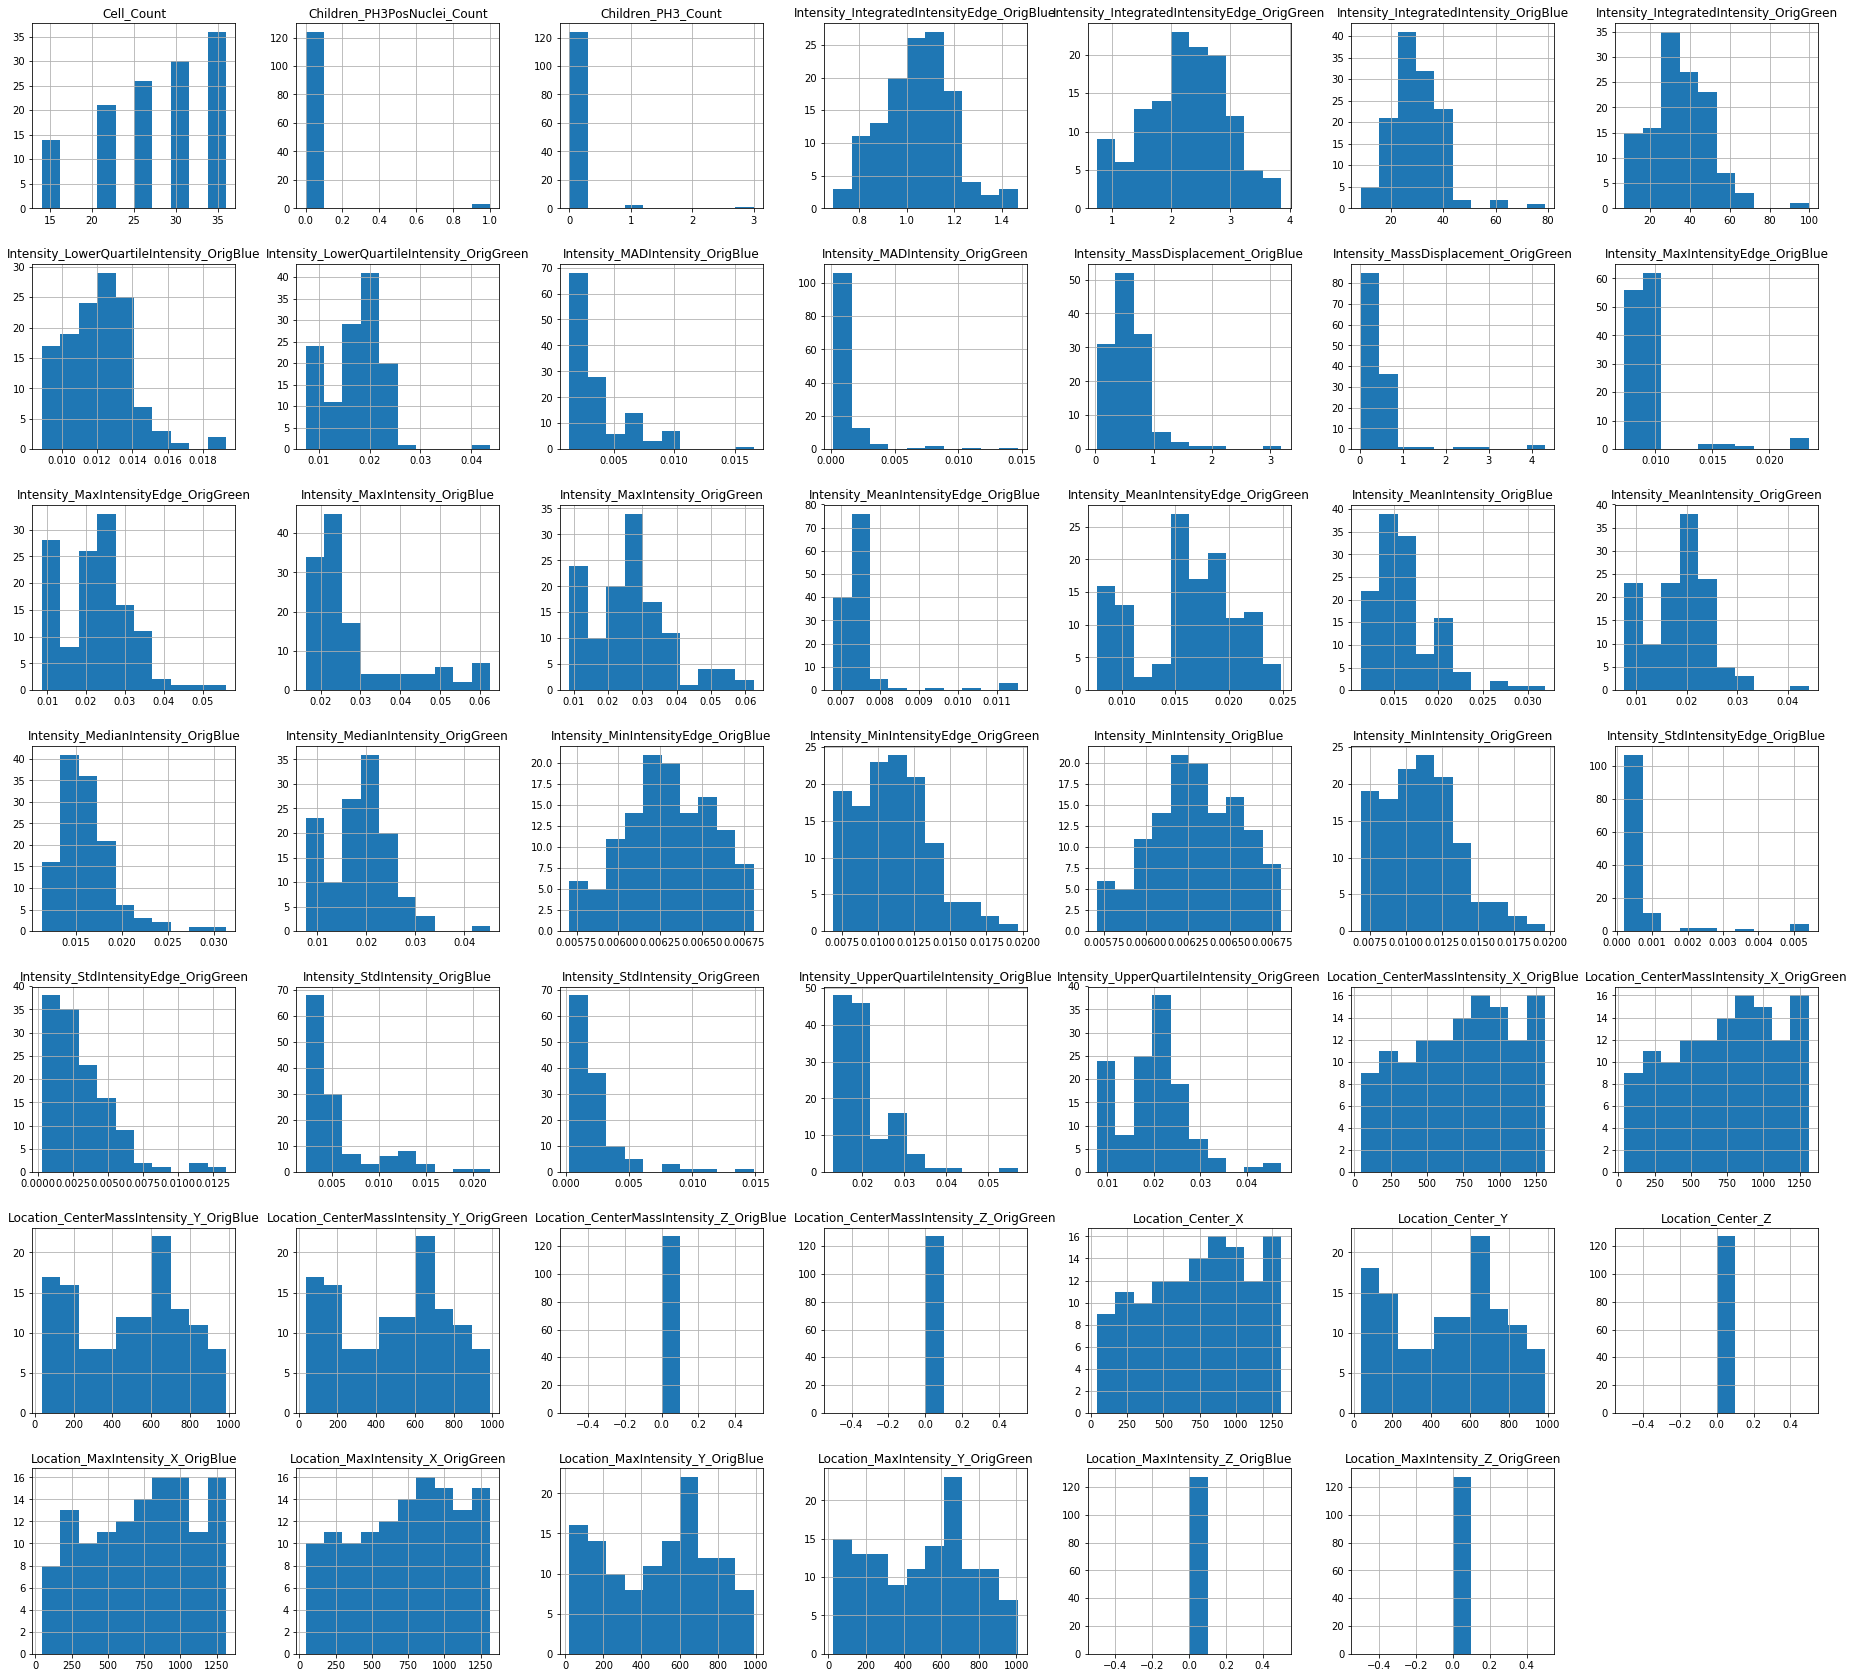

In [38]:
matplotlib.rcParams['figure.figsize'] = (32.0, 30.0)
# Drop few columns
df = Nuclei.drop(['Image', 'ImageNumber', 'Well', 'ObjectNumber', 'Number_Object_Number', 'Classify_PH3Neg', 'Classify_PH3Pos'], axis=1)
df.hist();

### Close the connection to the server

In [11]:
conn.close()

### License
Copyright (C) 2020-2021 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.